# Translation Quality Metrics Utilities

This notebook provides utilities for:
1. Calculating spelling error ratios between text pairs
2. Computing embedding distances using sentence transformers
3. Comprehensive translation quality metrics

In [2]:
from typing import Dict, Optional, Tuple
import numpy as np
import re
import difflib

# Auto-install required packages
try:
    from sentence_transformers import SentenceTransformer
    from scipy.spatial.distance import cosine, euclidean
except ImportError:
    print("Installing required packages...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sentence-transformers", "scipy"])
    from sentence_transformers import SentenceTransformer
    from scipy.spatial.distance import cosine, euclidean

/home/guyb/LLMs in multi agent system/agents-task3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class EmbeddingCalculator:
    """
    Singleton-like class for efficient embedding calculations.
    Caches the model to avoid reloading on every calculation.
    """
    _instance = None
    _model = None
    _model_name = None
    
    def __new__(cls):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
        return cls._instance
    
    def get_model(self, model_name: str = 'all-MiniLM-L6-v2') -> SentenceTransformer:
        """Load or retrieve cached sentence transformer model."""
        if self._model is None or self._model_name != model_name:
            self._model = SentenceTransformer(model_name)
            self._model_name = model_name
        return self._model

## Helper Functions

In [4]:
def _normalize_text(text: str) -> str:
    """Normalize text by removing punctuation and converting to lowercase."""
    text = re.sub(r'[.,!?;:\'"()\[\]{}<>]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower().strip()


def _calculate_word_difference_ratio(text1: str, text2: str) -> float:
    """Calculate ratio using symmetric difference of word sets.

    This version divides by the size of the union of both word sets so the
    returned ratio is always between 0.0 and 1.0 (0% - 100%)."""
    words1 = set(_normalize_text(text1).split())
    words2 = set(_normalize_text(text2).split())

    if not words1 and not words2:
        return 0.0

    differing_words = words1.symmetric_difference(words2)
    total_unique_words = len(words1.union(words2))

    return len(differing_words) / total_unique_words if total_unique_words > 0 else 0.0


def _calculate_levenshtein_ratio(text1: str, text2: str) -> float:
    """Calculate character-level Levenshtein distance ratio."""
    norm_text1 = _normalize_text(text1)
    norm_text2 = _normalize_text(text2)
    
    ratio = difflib.SequenceMatcher(None, norm_text1, norm_text2).ratio()
    return 1.0 - ratio


def _calculate_sequence_matcher_ratio(text1: str, text2: str) -> float:
    """Calculate error ratio using difflib.SequenceMatcher."""
    norm_text1 = _normalize_text(text1)
    norm_text2 = _normalize_text(text2)
    
    similarity = difflib.SequenceMatcher(None, norm_text1, norm_text2).ratio()
    return 1.0 - similarity

## Main Functions

In [5]:
def calculate_spelling_error_ratio(
    text1: str,
    text2: str,
    method: str = 'symmetric_difference'
) -> float:
    """
    Calculate the ratio of spelling/word errors between two text strings.
    
    This function compares two texts at the word level to determine how different
    they are. Useful for measuring translation quality degradation.
    
    Args:
        text1: First text string (typically the original)
        text2: Second text string (typically the final translation)
        method: Comparison method to use:
            - 'symmetric_difference': Words that appear in one text but not both
            - 'levenshtein': Character-level edit distance ratio
            - 'sequence_matcher': Uses difflib.SequenceMatcher for similarity
    
    Returns:
        float: Error ratio between 0.0 (identical) and 1.0 (completely different)
        
    Examples:
        >>> calculate_spelling_error_ratio("The cat sits", "The cat sits")
        0.0
        >>> calculate_spelling_error_ratio("The cat sits", "The dog runs")
        0.6667
    """
    if not text1 and not text2:
        return 0.0
    
    if not text1 or not text2:
        return 1.0
    
    if method == 'symmetric_difference':
        return _calculate_word_difference_ratio(text1, text2)
    elif method == 'levenshtein':
        return _calculate_levenshtein_ratio(text1, text2)
    elif method == 'sequence_matcher':
        return _calculate_sequence_matcher_ratio(text1, text2)
    else:
        raise ValueError(f"Unknown method: {method}. Use 'symmetric_difference', 'levenshtein', or 'sequence_matcher'")

In [6]:
def calculate_embedding_distance(
    text1: str,
    text2: str,
    model_name: str = 'all-MiniLM-L6-v2',
    return_all_metrics: bool = False
) -> float | Dict[str, float]:
    """
    Calculate semantic distance between two texts using sentence embeddings.
    
    This function uses state-of-the-art sentence transformers to create dense
    vector representations of texts and compute their semantic similarity.
    
    Args:
        text1: First text string
        text2: Second text string
        model_name: Sentence transformer model to use. Options:
            - 'all-MiniLM-L6-v2' (default, fast, 384 dimensions)
            - 'all-mpnet-base-v2' (slower, more accurate, 768 dimensions)
            - 'paraphrase-multilingual-MiniLM-L12-v2' (multilingual)
        return_all_metrics: If True, return dict with all distance metrics
    
    Returns:
        float: Cosine distance (0.0 = identical, 2.0 = opposite) if return_all_metrics=False
        dict: Dictionary with multiple metrics if return_all_metrics=True:
            - cosine_distance: 1 - cosine_similarity (0 to 2)
            - cosine_similarity: Cosine similarity (-1 to 1)
            - euclidean_distance: L2 distance between embeddings
            - manhattan_distance: L1 distance between embeddings
    
    Examples:
        >>> calculate_embedding_distance("The cat sits", "The cat sits")
        0.0
        >>> calculate_embedding_distance("I love pizza", "Pizza is great")
        0.234
    """
    if not text1 or not text2:
        return 1.0 if not return_all_metrics else {
            'cosine_distance': 1.0,
            'cosine_similarity': 0.0,
            'euclidean_distance': 0.0,
            'manhattan_distance': 0.0
        }
    
    # Get cached model
    calculator = EmbeddingCalculator()
    model = calculator.get_model(model_name)
    
    # Generate embeddings
    embedding1 = model.encode(text1, convert_to_numpy=True)
    embedding2 = model.encode(text2, convert_to_numpy=True)
    
    # Calculate cosine distance and similarity
    cos_dist = cosine(embedding1, embedding2)
    cos_sim = 1.0 - cos_dist
    
    if not return_all_metrics:
        return float(cos_dist)
    
    # Calculate additional metrics
    eucl_dist = euclidean(embedding1, embedding2)
    manh_dist = np.sum(np.abs(embedding1 - embedding2))
    
    return {
        'cosine_distance': float(cos_dist),
        'cosine_similarity': float(cos_sim),
        'euclidean_distance': float(eucl_dist),
        'manhattan_distance': float(manh_dist)
    }

In [7]:
def calculate_translation_quality_metrics(
    original: str,
    translated: str,
    model_name: str = 'all-MiniLM-L6-v2'
) -> Dict[str, float]:
    """
    Calculate comprehensive quality metrics for a translation pair.
    
    This is a convenience function that computes both spelling error ratio
    and embedding distance in a single call.
    
    Args:
        original: Original text
        translated: Translated text (after full translation chain)
        model_name: Sentence transformer model to use
    
    Returns:
        dict: Dictionary containing all quality metrics:
            - spelling_error_ratio: Word-level difference ratio
            - embedding_distance: Semantic distance (cosine)
            - embedding_similarity: Semantic similarity (1 - distance)
    
    Examples:
        >>> metrics = calculate_translation_quality_metrics(
        ...     "The cat sits on the mat",
        ...     "A cat is sitting on a mat"
        ... )
        >>> print(f"Error ratio: {metrics['spelling_error_ratio']:.2f}")
        >>> print(f"Semantic similarity: {metrics['embedding_similarity']:.2f}")
    """
    error_ratio = calculate_spelling_error_ratio(original, translated)
    embedding_dist = calculate_embedding_distance(original, translated, model_name)
    
    return {
        'spelling_error_ratio': float(error_ratio),
        'embedding_distance': float(embedding_dist),
        'embedding_similarity': float(1.0 - embedding_dist)
    }

## Example Usage

### Spelling Error Ratio Examples

In [8]:
# Example 1: Identical sentences
text1 = "The cat sits on the mat"
text2 = "The cat sits on the mat"
ratio = calculate_spelling_error_ratio(text1, text2)
print(f"Text 1: {text1}")
print(f"Text 2: {text2}")
print(f"Error Ratio: {ratio:.4f} ({ratio*100:.2f}%)\n")

Text 1: The cat sits on the mat
Text 2: The cat sits on the mat
Error Ratio: 0.0000 (0.00%)



In [9]:
# Example 2: Similar sentences with different words
text1 = "The cat sits on the mat"
text2 = "A feline rests on the rug"
ratio = calculate_spelling_error_ratio(text1, text2)
print(f"Text 1: {text1}")
print(f"Text 2: {text2}")
print(f"Error Ratio: {ratio:.4f} ({ratio*100:.2f}%)\n")

Text 1: The cat sits on the mat
Text 2: A feline rests on the rug
Error Ratio: 0.7778 (77.78%)



In [10]:
# Example 3: Different comparison methods
text1 = "The weather is beautiful today"
text2 = "The weather was beautiful yesterday"

for method in ['symmetric_difference', 'levenshtein', 'sequence_matcher']:
    ratio = calculate_spelling_error_ratio(text1, text2, method=method)
    print(f"Method: {method:25s} -> Error Ratio: {ratio:.4f}")

Method: symmetric_difference      -> Error Ratio: 0.5714
Method: levenshtein               -> Error Ratio: 0.1385
Method: sequence_matcher          -> Error Ratio: 0.1385


### Embedding Distance Examples

In [11]:
# Example 1: Identical sentences
text1 = "The cat sits on the mat"
text2 = "The cat sits on the mat"
distance = calculate_embedding_distance(text1, text2)
print(f"Text 1: {text1}")
print(f"Text 2: {text2}")
print(f"Embedding Distance: {distance:.4f}")
print(f"Similarity: {(1-distance)*100:.2f}%\n")

Text 1: The cat sits on the mat
Text 2: The cat sits on the mat
Embedding Distance: 0.0000
Similarity: 100.00%



In [12]:
# Example 2: Semantically similar sentences
text1 = "The cat sits on the mat"
text2 = "A feline rests on the rug"
distance = calculate_embedding_distance(text1, text2)
print(f"Text 1: {text1}")
print(f"Text 2: {text2}")
print(f"Embedding Distance: {distance:.4f}")
print(f"Similarity: {(1-distance)*100:.2f}%\n")

Text 1: The cat sits on the mat
Text 2: A feline rests on the rug
Embedding Distance: 0.4393
Similarity: 56.07%



In [13]:
# Example 3: Different sentences
text1 = "I love programming in Python"
text2 = "The weather is beautiful today"
distance = calculate_embedding_distance(text1, text2)
print(f"Text 1: {text1}")
print(f"Text 2: {text2}")
print(f"Embedding Distance: {distance:.4f}")
print(f"Similarity: {(1-distance)*100:.2f}%\n")

Text 1: I love programming in Python
Text 2: The weather is beautiful today
Embedding Distance: 0.9339
Similarity: 6.61%



In [14]:
# Example 4: All metrics
text1 = "The quick brown fox jumps over the lazy dog"
text2 = "The fast brown fox leaps over the lazy dog"
metrics = calculate_embedding_distance(text1, text2, return_all_metrics=True)
print(f"Text 1: {text1}")
print(f"Text 2: {text2}")
print("\nAll Metrics:")
for key, value in metrics.items():
    print(f"  {key:25s}: {value:.4f}")

Text 1: The quick brown fox jumps over the lazy dog
Text 2: The fast brown fox leaps over the lazy dog

All Metrics:
  cosine_distance          : 0.0257
  cosine_similarity        : 0.9743
  euclidean_distance       : 0.2269
  manhattan_distance       : 3.4938


### Translation Quality Metrics Examples

In [15]:
# Example: Comprehensive translation quality assessment
original = "The cat sits on the mat"
back_translated = "A cat is sitting on a mat"

metrics = calculate_translation_quality_metrics(original, back_translated)
print(f"Original: {original}")
print(f"Back-translated: {back_translated}")
print("\nQuality Metrics:")
print(f"  Spelling Error Ratio: {metrics['spelling_error_ratio']:.4f} ({metrics['spelling_error_ratio']*100:.2f}%)")
print(f"  Embedding Distance: {metrics['embedding_distance']:.4f}")
print(f"  Embedding Similarity: {metrics['embedding_similarity']:.4f} ({metrics['embedding_similarity']*100:.2f}%)")
print(f"\nInterpretation: A similarity of {metrics['embedding_similarity']*100:.1f}% suggests the translation preserved meaning {'well' if metrics['embedding_similarity'] > 0.7 else 'moderately' if metrics['embedding_similarity'] > 0.5 else 'poorly'}.")

Original: The cat sits on the mat
Back-translated: A cat is sitting on a mat

Quality Metrics:
  Spelling Error Ratio: 0.6250 (62.50%)
  Embedding Distance: 0.0274
  Embedding Similarity: 0.9726 (97.26%)

Interpretation: A similarity of 97.3% suggests the translation preserved meaning well.


In [16]:
# Example: Compare multiple translations
original = "I love programming in Python"
translations = [
    "Python programming is something I enjoy",
    "I enjoy coding with Python",
    "Programming in Python is fun for me",
    "The weather is nice today"  # Poor translation
]

print(f"Original: {original}\n")
for i, trans in enumerate(translations, 1):
    metrics = calculate_translation_quality_metrics(original, trans)
    print(f"Translation {i}: {trans}")
    print(f"  Similarity: {metrics['embedding_similarity']*100:.1f}%, Error Ratio: {metrics['spelling_error_ratio']*100:.1f}%\n")

Original: I love programming in Python

Translation 1: Python programming is something I enjoy
  Similarity: 91.9%, Error Ratio: 62.5%

Translation 2: I enjoy coding with Python
  Similarity: 92.9%, Error Ratio: 75.0%

Translation 3: Programming in Python is fun for me
  Similarity: 91.7%, Error Ratio: 66.7%

Translation 4: The weather is nice today
  Similarity: 8.0%, Error Ratio: 100.0%



### Real implementation

Example 1

In [17]:
original_sentence = "The Trump administration is eager to use the momentum of talks with Ukrainian and Russian officials to try and force both Presidents Volodymyr Zelensky and Vladimir Putin to the table on an initial ceasefire deal, those sources said"
errored_sentence = "The Trump adminstration is egar to use the momemtum of talks with Ukrianian and Russain officals to try and force both President Volodymyr Zelensky and Vladmir Putin to the tabel on an inital ceasefire deal, thoze sources said."


In [18]:
ratio = calculate_spelling_error_ratio(original_sentence, errored_sentence)
print(f"Error Ratio: {ratio:.4f} ({ratio*100:.2f}%)\n")

Error Ratio: 0.5116 (51.16%)



In [19]:
translated_sentence = "The Trump administration is eager to exploit the momentum of the talks with the Ukrainian and Russian officials in order to try to force both President Volodymyr Zelensky and Vladimir Putin to the negotiating table on an initial ceasefire agreement, those sources said."

In [20]:
ratio = calculate_embedding_distance(original_sentence, translated_sentence)
print(f" Embedding distance: {ratio:.4f} ({ratio*100:.2f}%)\n")

 Embedding distance: 0.0389 (3.89%)



Example 2

In [21]:
original_sentence = "I've successfully used the dangerous flag for extended tasks, including one memorable 9-hour session where Claude built an entire financial data analysis system. The requirements were:"
errored_sentence = "I've sucessfuly uzed the dangrous flag for extanded tascs, incloding one memorabel 9 hour sesion where Claud built an entir financhal data analisis systam. The reqwirements wer:"

In [22]:
ratio = calculate_spelling_error_ratio(original_sentence, errored_sentence)
print(f"Error Ratio: {ratio:.4f} ({ratio*100:.2f}%)\n")

Error Ratio: 0.7857 (78.57%)



In [23]:
translated_sentence = "I successfully used the dangerous flag for extended tasks, including an unforgettable 9-hour session in which Claude built a complete financial data analysis system. The requirements were:"

In [24]:
ratio = calculate_embedding_distance(original_sentence, translated_sentence)
print(f"Embedding distance: {ratio:.4f} ({ratio*100:.2f}%)\n")

Embedding distance: 0.0318 (3.18%)



Example 3: long one

In [25]:
original_sentence = "The rest of the chapter deftly places us at the heart of the story by showcasing Austen’s brilliant characterisation.  We are introduced to Mr and Mrs Bennet and we understand their relationship and the inequality of their marriage.  He has become a long-suffering husband who is reduced to scoring victories through quiet sarcasm, which she is a nag, a gossip and a social climber.  Nevertheless, Austen loves them and we can see that in her affectionate treatment of their foibles.  Impressively Austen also manages to introduce through the Bennets’ conversation no less than ten other characters!  Of course we hear about the impressive Bingley and his four or five thousand a year, but we also learn that the Bennets have five grown up daughters, we hear the names and main character traits of three of them, we know which ones each parent prefers and we even have the first mention of Sir William and Lady Lucas as a rival family the Bennets need to keep up with.  There’s also a couple of side characters thrown into to the gossipy mix.  All this is done in so natural and deft a way that we happily throw ourselves into chapter two with a good basic knowledge of and fondness for the family."
mispelled_sentence = "The rest of the chaptr defly plasces us at the hart of the storry by showcasng Austen’s brilant caracterisashun. We are introdused to Mr and Mrs Bennet and we undrstand their relashunship and the inequlity of their marrige. He has becum a long sufering husbend who is reducd to scorring victoris through quiet sarkasm, while she is a nag, a gosip and a socal climber. Nevrtheless, Austen luvs them and we can see that in her afectionate treetment of their foibls. Immpresively Austen also maneges to introdce through the Bennets’ conversashun no less than ten othr charactrs. Of cours we hear about the impresive Bingley and his four or five thosand a year, but we also lern that the Bennets have five groan up daughtrs, we heer the names and main caracter trates of three of them, we know which ones each parent preffers and we even have the first menshun of Sir William and Lady Lucas as a rival fammily the Bennets need to keep up with. Ther’s also a cupple of side charactrs thrown into the gossipy mix. All this is done in so naturul and defte a way that we hapily throw ourselvs into chaptr two with a good basic knoledge of and fondness for the famly."

In [26]:
ratio = calculate_spelling_error_ratio(original_sentence, mispelled_sentence)
print(f"Error Ratio: {ratio:.4f} ({ratio*100:.2f}%)\n")

Error Ratio: 0.5550 (55.50%)



In [27]:
translated_sentence = "The rest of the chapter skillfully places us at the heart of the story while highlighting Austen's brilliant characterization. We meet Mr. and Mrs. Bennet and understand the relationship between them and the inequality in their marriage. He has become a long-suffering husband, reduced to victories through quiet sarcasm, while she is nagging, gossipy, and a social climber. Nevertheless, Austen loves them and we can see this in her affectionate treatment of their weaknesses. Impressively, Austen also manages to introduce through the Bennets' conversation no less than ten additional characters. Of course we hear about the impressive Bingley and his four or five thousand pounds a year, but we also learn that the Bennets have five grown daughters, we hear the names and main character traits of three of them, we know which ones each parent prefers, and we even have the first mention of Sir William and Lady Lucas as a rival family the Bennets need to compete with. There are also some secondary characters thrown into the gossipy mix. All this is done in such a natural and skillful way that we happily throw ourselves into the second chapter with good basic knowledge and affection for the family."

In [28]:
ratio = calculate_embedding_distance(original_sentence, translated_sentence)
print(f"Embedding distance: {ratio:.4f} ({ratio*100:.2f}%)\n")

Embedding distance: 0.0212 (2.12%)



Columns found in CSV: ['original_sentence', 'mispelled_sentence', 'spelling_error_ratio', 'french_translation', 'hebrew_translation', 'final_english_translation', 'embedding_distance']
Using columns: spell="spelling_error_ratio", embed="embedding_distance"


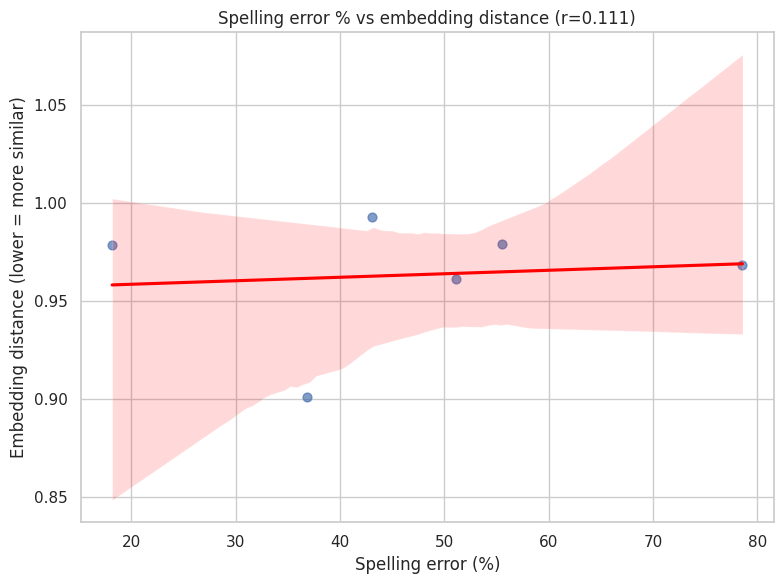

Plot saved to: spelling_vs_embedding.png


In [30]:
# ---- Load CSV ----
csv_path = 'translation_experiments.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found: {csv_path}. Make sure it's in the repo root.")

df = pd.read_csv(csv_path)
print("Columns found in CSV:", list(df.columns))

# ---- Select correct spelling-error column (must be numeric) ----
numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

spell_candidates = [c for c in numeric_cols
                    if 'spell' in c.lower() or 'error' in c.lower() or 'ratio' in c.lower()]

if not spell_candidates:
    raise ValueError("No numeric spelling error column found. Must include 'spell', 'error', or 'ratio'.")

spell_col = spell_candidates[0]

# ---- Select embedding distance column (numeric) ----
embed_candidates = [c for c in numeric_cols
                    if 'embed' in c.lower() or 'distance' in c.lower() or 'similar' in c.lower()]

if not embed_candidates:
    raise ValueError("No numeric embedding distance/similarity column found.")

embed_col = embed_candidates[0]

print(f'Using columns: spell="{spell_col}", embed="{embed_col}"')


# ---- Normalize spelling to percentage (0–100) ----
spell_vals = df[spell_col].astype(float)

if spell_vals.max() <= 1.0:
    spelling_pct = spell_vals * 100.0
else:
    spelling_pct = spell_vals.copy()


# ---- Normalize embedding distance ----
embed_vals = df[embed_col].astype(float)

embed_is_similarity = (
    'similar' in embed_col.lower() or
    (embed_vals.max() <= 1.0 and embed_vals.min() >= -1.0)
)

if embed_is_similarity:
    embedding_distance = 1.0 - embed_vals
else:
    embedding_distance = embed_vals.copy()


# ---- Build plotting dataframe ----
plot_df = pd.DataFrame({
    'spelling_pct': spelling_pct,
    'embedding_distance': embedding_distance
}).dropna()


# ---- Pearson correlation ----
if len(plot_df) >= 2:
    r = np.corrcoef(plot_df['spelling_pct'], plot_df['embedding_distance'])[0, 1]
else:
    r = float("nan")


# ---- Plot ----
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))

sns.regplot(
    x='spelling_pct',
    y='embedding_distance',
    data=plot_df,
    scatter_kws={'s': 40, 'alpha': 0.7},
    line_kws={'color': 'red'}
)

plt.xlabel('Spelling error (%)')
plt.ylabel('Embedding distance (lower = more similar)')
plt.title(f'Spelling error % vs embedding distance (r={r:.3f})')

plt.tight_layout()
out_img = 'spelling_vs_embedding.png'
plt.savefig(out_img, dpi=150)
plt.show()

print(f"Plot saved to: {out_img}")